<a href="https://colab.research.google.com/github/HaHyunkyung/Vehicle_Damage_Classification/blob/main/%EC%B0%A8%EB%9F%89%ED%8C%8C%EC%86%90%EC%97%AC%EB%B6%80%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **차량 공유업체의 차량 파손 여부 분류하기**

## 1.환경설정

In [ ]:
!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.0 which is incompatible.


In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [ ]:
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

#### 1) 데이터 다운로드

In [ ]:
def download_file(file_id, save_path) :
    if os.path.exists(save_path) :
        print(f'{save_path} 파일이 이미 존재합니다.')
        return

    gdown.download(id=file_id, output=save_path, quiet=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_id = '1JHo4Rsb8Mx-sJqu7xdQWUgrfAf3H1g7W'

download_file(file_id, 'car_images.zip')

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1JHo4Rsb8Mx-sJqu7xdQWUgrfAf3H1g7W

but Gdown can't. Please check connections and permissions.

#### 2) 데이터 압축 해제

In [ ]:
def dataset_extract(file_name):
    with zipfile.ZipFile(file_name,'r') as zip_ref:
        file_list = zip_ref.namelist()

        if os.path.exists(f'/content/{file_name[-14:-4]}/'):
            print(f'데이터셋 폴더가 이미 존재합니다.')
            return

        else:
            for f in tqdm(file_list, desc = 'Extracting', unit = 'files'):
                zip_ref.extract(member = f, path=f'/content/{file_name[-14:-4]}/')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_extract('/content/drive/MyDrive/KT 시각지능 미프 1차/Car_Images.zip')

Extracting: 100%|██████████| 607/607 [00:17<00:00, 35.06files/s]


#### 3) 데이터 조회

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random
from PIL import Image

In [ ]:
def count_images_in_folders(root_dir):
    categories = ['normal', 'abnormal']
    for category in categories:
        path = os.path.join(root_dir, category)
        count = len(os.listdir(path))
        print(f"Total images in {category}: {count}")

In [ ]:
def show_random_image_and_shape(root_dir, category):
    path = os.path.join(root_dir, category)
    image_files = os.listdir(path)
    random_image = random.choice(image_files)
    image_path = os.path.join(path, random_image)
    img = Image.open(image_path)
    img_arr = np.array(img)
    print(f"Shape of the {category} image: {img_arr.shape}")
    plt.imshow(img_arr)
    plt.title(f"{category} image")
    plt.axis('off')  # Hide the axis
    plt.show()


In [ ]:
dataset_root_dir = '/content/drive/MyDrive/KT 시각지능 미프 1차/Car_Images'

In [ ]:
# 폴더별 이미지 데이터 갯수 확인
count_images_in_folders(dataset_root_dir)

Total images in normal: 302
Total images in abnormal: 303


Shape of the normal image: (1024, 1024, 3)


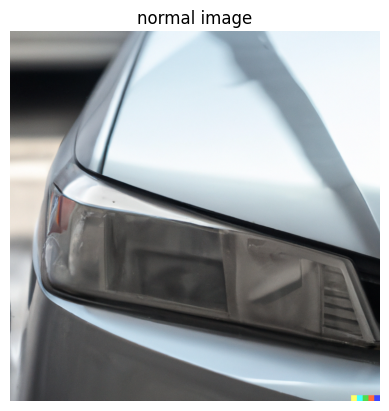

In [ ]:
# 정상 차량 랜덤 이미지 확인 및 형태 확인
show_random_image_and_shape(dataset_root_dir, 'normal')

Shape of the abnormal image: (1024, 1024, 3)


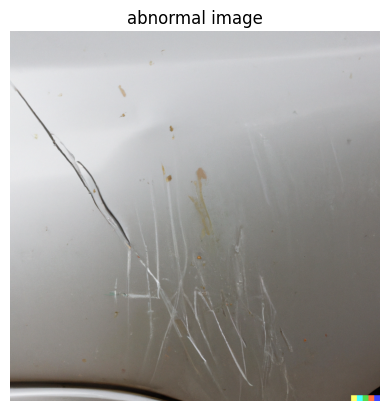

In [ ]:
# 파손 차량 랜덤 이미지 확인 및 형태 확인
show_random_image_and_shape(dataset_root_dir, 'abnormal')

## 2.데이터 전처리

### (1) Y : 클래스 만들기

In [ ]:
y_normal = np.zeros((302,))
y_abnormal = np.ones((303,))

Y = np.hstack((y_normal, y_abnormal))
Y.shape

(605,)

In [ ]:
Y[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### (2) X : 데이터 리스트 통합

In [ ]:
X = glob.glob('/content/drive/MyDrive/KT 시각지능 미프 1차/Car_Images/normal/*') + glob.glob('/content/drive/MyDrive/KT 시각지능 미프 1차/Car_Images/abnormal/*')
X[:3]

['/content/drive/MyDrive/KT 시각지능 미프 1차/Car_Images/normal/DALLíñE 2023-03-10 22.22.18 - photo of a part of car.png',
 '/content/drive/MyDrive/KT 시각지능 미프 1차/Car_Images/normal/DALLíñE 2023-03-10 18.52.40 - photo of a part of car.png',
 '/content/drive/MyDrive/KT 시각지능 미프 1차/Car_Images/normal/DALLíñE 2023-03-10 22.23.54 - photo of a part of car.png']

### (3) 데이터셋 분리

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y ,test_size = .1, random_state = 2024)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = .1, random_state = 2024)

In [ ]:
len(x_train), y_train.shape, len(x_val), y_val.shape

(489, (489,), 55, (55,))

### (4) X : image to array

In [ ]:
import keras

In [ ]:
def x_preprocessing(img_list) :
    bin_list = []

    for img in tqdm(img_list) :
        img = keras.utils.load_img(img, target_size=(128,128) )
        img = keras.utils.img_to_array(img)
        bin_list.append(img)

    return np.array(bin_list)

In [ ]:
x_tr_arr = x_preprocessing(x_train)
x_val_arr = x_preprocessing(x_val)
x_te_arr = x_preprocessing(x_test)

100%|██████████| 61/61 [00:22<00:00,  2.70it/s]


In [ ]:
x_tr_arr.shape, x_val_arr.shape, x_te_arr.shape

((489, 128, 128, 3), (55, 128, 128, 3), (61, 128, 128, 3))

In [ ]:
x_tr_arr.shape, y_train.shape

((489, 128, 128, 3), (489,))

## 3.모델링

In [ ]:
import keras

from keras.utils import clear_session
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPool2D, RandomRotation

#### 1) 구조 설계

In [ ]:
clear_session()

model = Sequential()

model.add(Input(shape = (128,128,3)))

model.add(RandomRotation(0.2))

model.add( Conv2D(32, (3,3), (1,1), 'same', activation='relu') )
model.add( Conv2D(32, (3,3), (1,1), 'same', activation='relu') )
model.add( MaxPool2D((2,2), (2,2)) )
model.add( BatchNormalization() )
model.add( Dropout(0.4) )

model.add( Conv2D(64, (3,3), (1,1), 'same', activation='relu') )
model.add( Conv2D(64, (3,3), (1,1), 'same', activation='relu') )
model.add( MaxPool2D((2,2), (2,2)) )
model.add( BatchNormalization() )
model.add( Dropout(0.4) )

model.add( Conv2D(128, (3,3), (1,1), 'same', activation='relu') )
model.add( Conv2D(128, (3,3), (1,1), 'same', activation='relu') )
model.add( MaxPool2D((2,2), (2,2)) )
model.add( BatchNormalization() )
model.add( Dropout(0.4) )

model.add( Flatten() )
model.add( Dense(128, activation='relu'))
model.add( Dense(1, activation='sigmoid') )

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_rotation (RandomRotation)     │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,482,465 (17.10 MB)

 Trainable params: 4,482,017 (17.10 MB)

 Non-trainable params: 448 (1.75 KB)

#### 2) 학습

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True
                   )

In [ ]:
history = model.fit(x_tr_arr, y_train, validation_data=(x_val_arr, y_val),
                    epochs=10000, verbose=1,
                    callbacks=[es]
                    )

Epoch 1/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 205ms/step - accuracy: 0.5926 - loss: 1.9754 - val_accuracy: 0.4727 - val_loss: 4.2953
Epoch 2/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8137 - loss: 0.5284 - val_accuracy: 0.4727 - val_loss: 5.4245
Epoch 3/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7894 - loss: 0.5104 - val_accuracy: 0.4727 - val_loss: 4.9884
Epoch 4/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8211 - loss: 0.4214 - val_accuracy: 0.4727 - val_loss: 0.6832
Epoch 5/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8543 - loss: 0.4156 - val_accuracy: 0.5091 - val_loss: 0.7242
Epoch 6/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8588 - loss: 0.3498 - val_accuracy: 0.5636 - val_loss: 0.6791
Epoch 7/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8807 - loss: 0.3262 - val_accuracy: 0.7818 - val_loss: 0.5057
Epoch 8/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8223 - loss: 0.4109 

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [ ]:
train_predictions = model.predict(x_tr_arr)
valid_predictions = model.predict(x_val_arr)
test_predictions = model.predict(x_te_arr)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
train_predictions_binary = (train_predictions > 0.5).astype('int32').flatten()
valid_predictions_binary = (valid_predictions > 0.5).astype('int32').flatten()
test_predictions_binary = (test_predictions > 0.5).astype('int32').flatten()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# 훈련 세트 평가
print("Train Set Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_train, train_predictions_binary))
print("Classification Report:")
print(classification_report(y_train, train_predictions_binary))

# 검증 세트 평가
print("\nValidation Set Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, valid_predictions_binary))
print("Classification Report:")
print(classification_report(y_val, valid_predictions_binary))

# 테스트 세트 평가
print("\nTest Set Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions_binary))
print("Classification Report:")
print(classification_report(y_test, test_predictions_binary))

Train Set Evaluation:
Confusion Matrix:
[[190  53]
 [ 29 217]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.78      0.82       243
         1.0       0.80      0.88      0.84       246

    accuracy                           0.83       489
   macro avg       0.84      0.83      0.83       489
weighted avg       0.84      0.83      0.83       489


Validation Set Evaluation:
Confusion Matrix:
[[20  6]
 [ 6 23]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77        26
         1.0       0.79      0.79      0.79        29

    accuracy                           0.78        55
   macro avg       0.78      0.78      0.78        55
weighted avg       0.78      0.78      0.78        55


Test Set Evaluation:
Confusion Matrix:
[[28  5]
 [ 2 26]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.85  

## 4.모델링 II

### (1) image_dataset_from_directory

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
batch_size = 32
image_size = (128, 128)

train_dataset = image_dataset_from_directory(
    dataset_root_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size)

validation_dataset = image_dataset_from_directory(
    dataset_root_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size)

Found 605 files belonging to 2 classes.
Using 545 files for training.
Found 605 files belonging to 2 classes.
Using 60 files for validation.


### (2) Transfer Learning

#### 1) Inception V3 모델을 불러와서 저장하기

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

#### 2) Inception V3 모델과 연결하여 구조 설계

In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

x = data_augmentation(inputs)  # 입력 데이터에 데이터 증강 적용
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model(x, training=False)  # base_model을 통과시킨 후 training=False로 설정하여 Dropout 등을 비활성화
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 요약
model.summary()

Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_16 (Sequential)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_14 (TrueDivide)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_14 (Subtract)               │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_14          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

#### 3) 학습

In [ ]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True
                   )

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10000,
    callbacks=[es]
)

Epoch 1/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.6032 - loss: 0.7650 - val_accuracy: 0.7833 - val_loss: 0.5165
Epoch 2/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.7981 - loss: 0.4770 - val_accuracy: 0.8167 - val_loss: 0.4326
Epoch 3/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.8219 - loss: 0.4136 - val_accuracy: 0.8333 - val_loss: 0.3895
Epoch 4/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.8873 - loss: 0.2975 - val_accuracy: 0.8333 - val_loss: 0.3551
Epoch 5/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.8693 - loss: 0.2912 - val_accuracy: 0.8333 - val_loss: 0.3920
Epoch 6/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8837 - loss: 0.2744 - val_accuracy: 0.8333 - val_loss: 0.3771
Epoch 7/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.8828 - loss: 0.3059 - val_accuracy: 0.8000 - val_loss: 0.5862
Epoch 8/10000
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.8942 - loss: 0.3146 

#### 4) 성능 평가

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8368 - loss: 0.3387 
Validation loss: 0.35509833693504333
Validation accuracy: 0.8333333134651184
